Steane code decoding with no noise
===================================

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla

3. Set up the error correction circuit.  There are options to set this circuit up with and without MCT gates.

3. Force an error and then check that this error is corrected. Since there is no noise the error should always be corrected.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

DATA_QUBITS = 7
ANCILLA_QUBITS = 3

FAIL_X = True   #Introduce a Pauli X failure in one bit
FAIL_Z = True   #Introduce a Pauli Z failure in one bit

ERROR_REDUCTION = 1
NOISE = False                                             #Test with noise
SHOTS = 100                                               #Number of shots to run    
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022 * ERROR_REDUCTION           #Two gate noise 

SIMULATOR = Aer.get_backend('qasm_simulator')

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


Error decoding
---------------------

The error decoding circuit is added to the encoding circuit, the ancilla and the error correction circuit and all are transpiled.  There are two possible circuits, those with Multi Control Toffoli (MCT) gates, and those without.

After error correction we always expect an error rate of zero as there is no noise.

In [5]:
valid_codeword = ['0000000']
for mct in [True, False]:
    if mct:
        print('MCT gates used')
    else:
        print('MCT gates not used')
    for index in range(DATA_QUBITS):
        if mct:
            qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = False)
        else:
            qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = True)
        qubit.set_up_logical_zero()
        qubit.barrier()

        if FAIL_X:
            qubit.force_X_error(index)   #force X error for testing
        if FAIL_Z:
            qubit.force_Z_error(index)   #force Z error for testing
        qubit.barrier()
        qubit.set_up_ancilla()
        qubit.barrier()
        if mct:     #Multi Control Toffoli (MCT) gates
            qubit.correct_errors(mct = True)
        else:
            qubit.correct_errors()
        qubit.barrier()
        qubit.decode()
        qubit.barrier()
        if NOISE:
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING)
        qubit.logical_measure_data()
        qubit.logical_measure_ancilla()
        qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
        if NOISE:
            result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qt, SIMULATOR, shots = SHOTS).result()
        counts = result.get_counts(qt)
        print(f'Results for error introduced on qubit index {index}')
        print ('The simulated result after error correction are', counts)
        if mct:
            count_valid, count_invalid, _ = count_valid_output_strings(counts, valid_codeword, 2)
        else:
            count_valid, count_invalid, _ = count_valid_output_strings(counts, valid_codeword, 3)
        error_rate = count_invalid / SHOTS
        print(f'The error rate is {error_rate:.4f}')
        print()

MCT gates used
Results for error introduced on qubit index 0
The simulated result after error correction are {'100 100 0000000': 100}
The error rate is 0.0000

Results for error introduced on qubit index 1
The simulated result after error correction are {'010 010 0000000': 100}
The error rate is 0.0000

Results for error introduced on qubit index 2
The simulated result after error correction are {'110 110 0000000': 100}
The error rate is 0.0000

Results for error introduced on qubit index 3
The simulated result after error correction are {'001 001 0000000': 100}
The error rate is 0.0000

Results for error introduced on qubit index 4
The simulated result after error correction are {'101 101 0000000': 100}
The error rate is 0.0000

Results for error introduced on qubit index 5
The simulated result after error correction are {'011 011 0000000': 100}
The error rate is 0.0000

Results for error introduced on qubit index 6
The simulated result after error correction are {'111 111 0000000': 1

Draw circuit

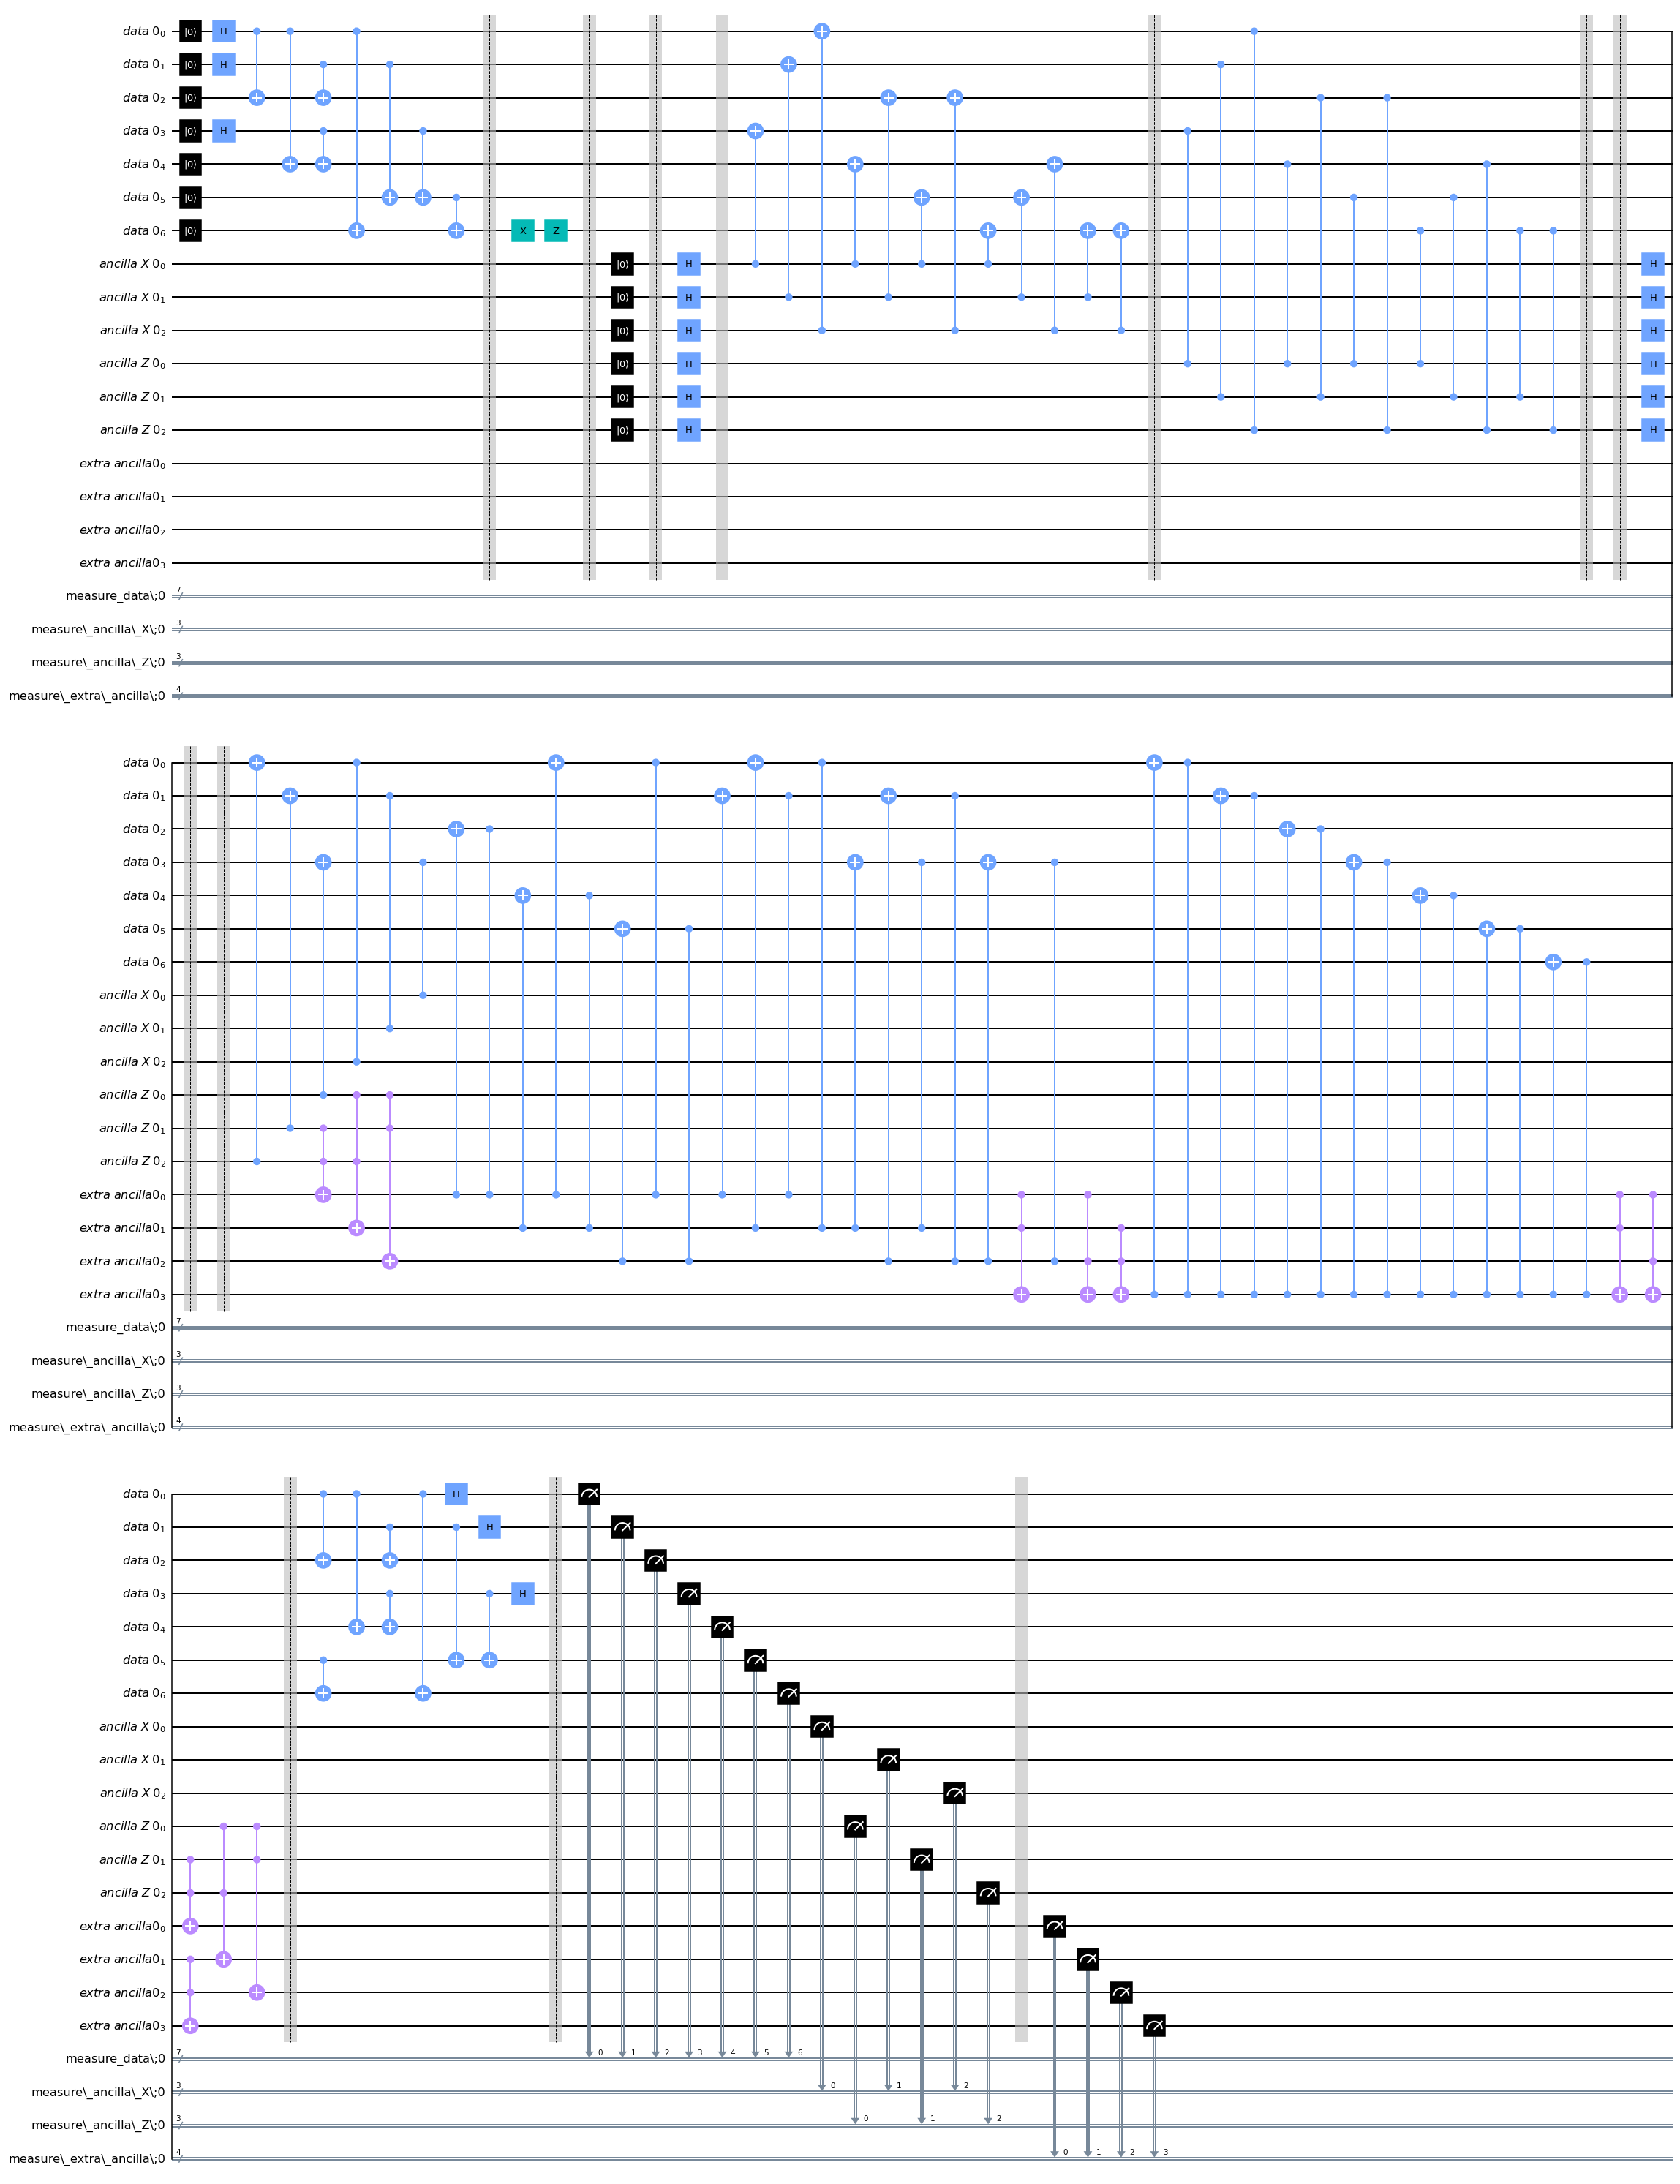

In [6]:
qubit.draw(output = 'mpl', filename = './circuits/Steane_code_circuit.jpg', fold = 45)

Draw transpiled circuit

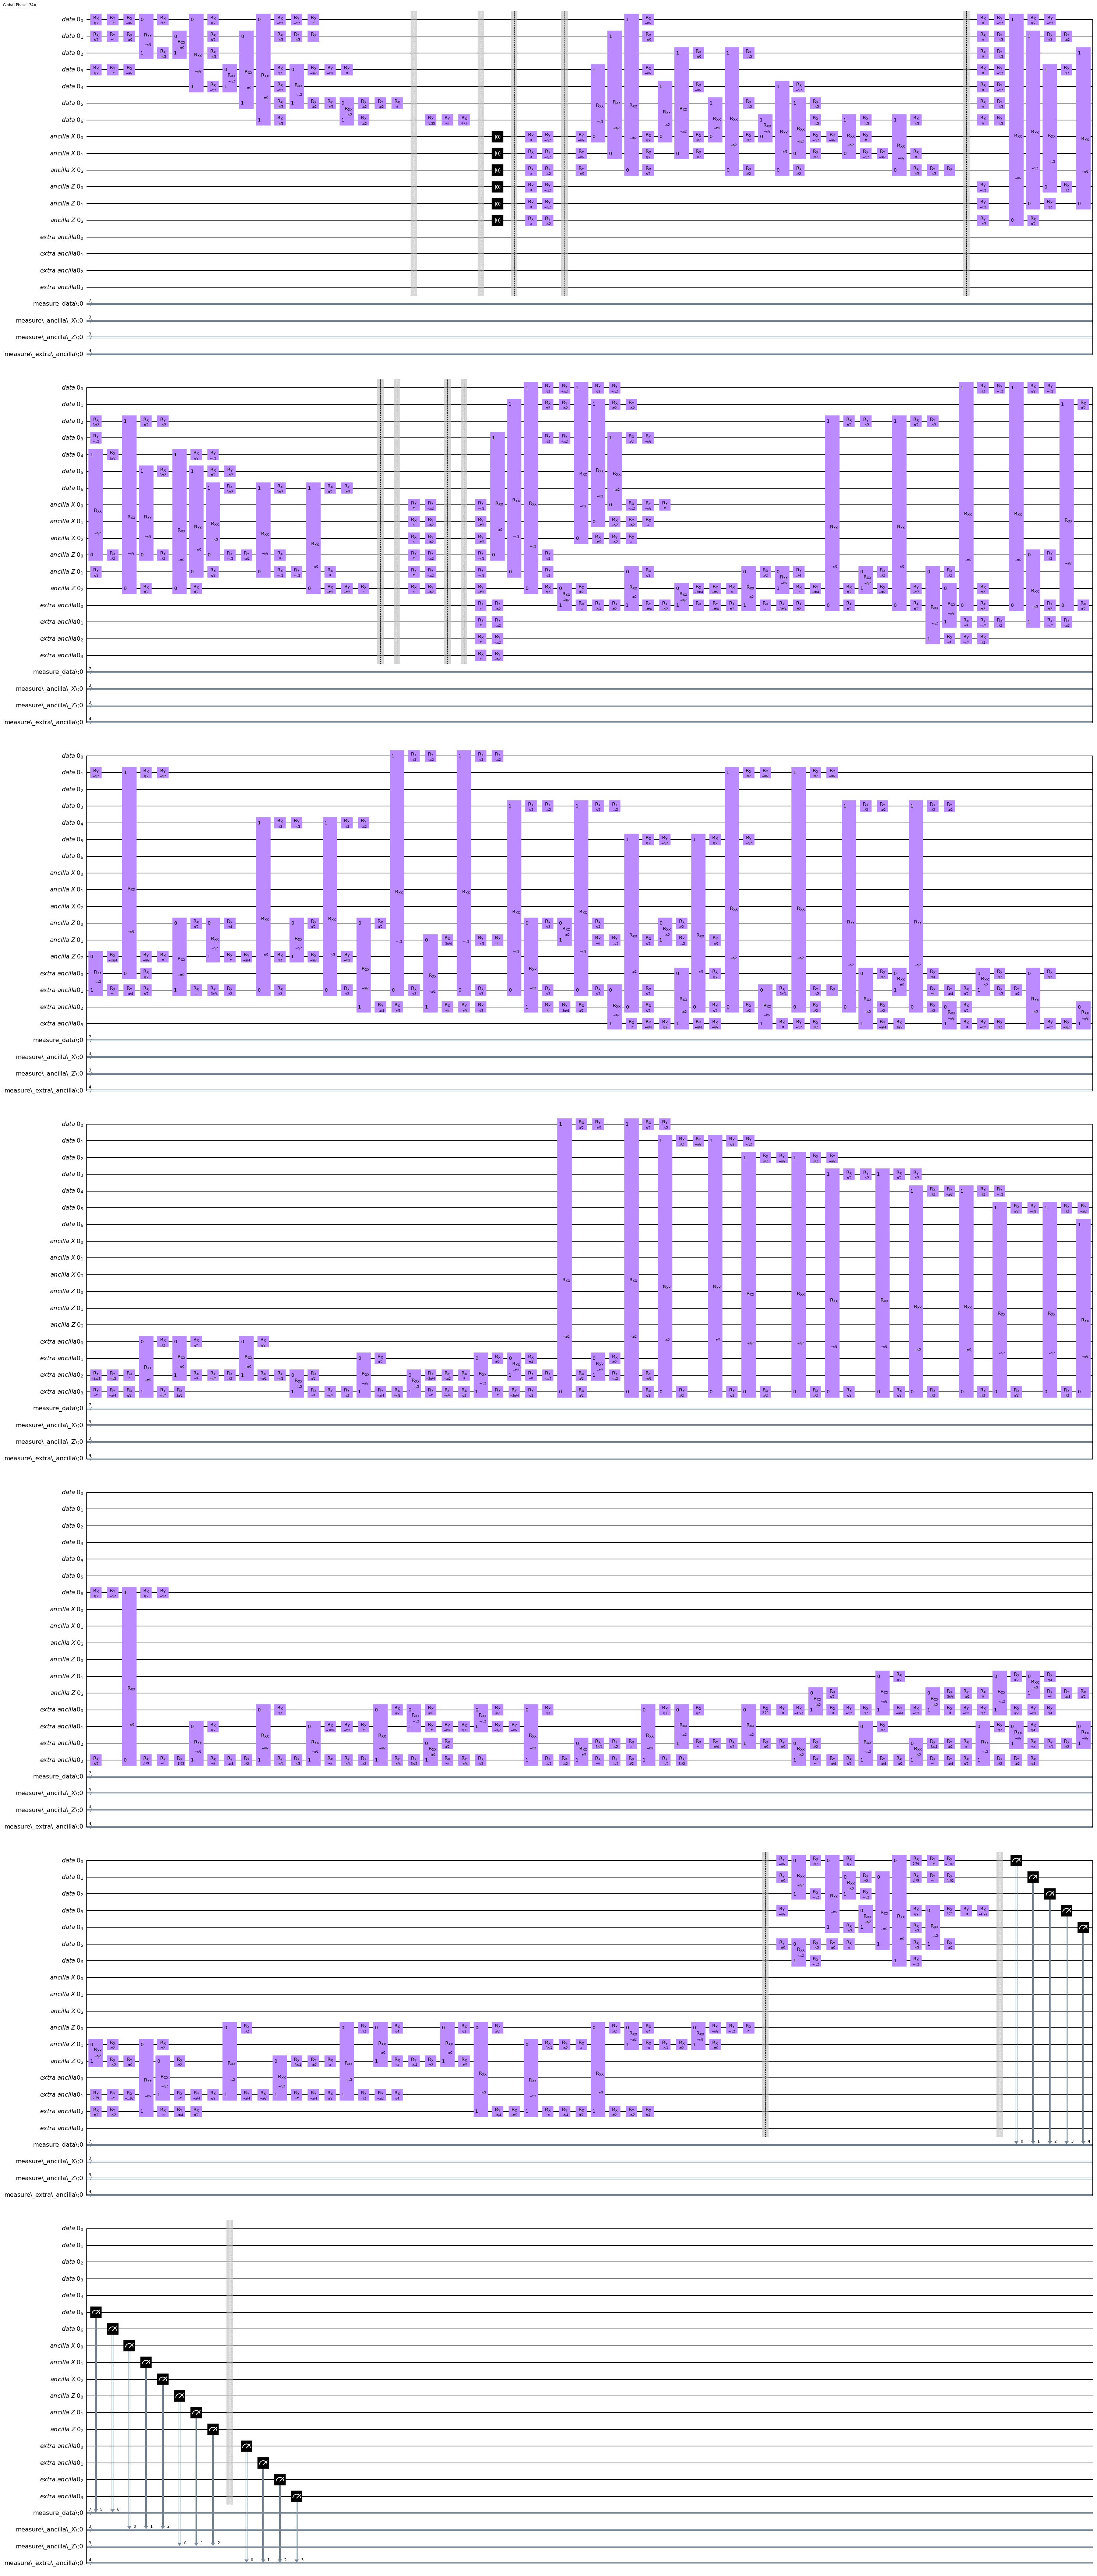

In [7]:
qt.draw(output = 'mpl', filename = './circuits/Steane_code_circuit_transpiled.jpg', fold = 60)